In [158]:
import pandas as pd

# Load Data
df = pd.read_csv("AA.Complete Data.csv")
df = df.drop(columns = ["MW Supply"])

# Convert Timestamp into separate features
df["DATE & TIME"] = pd.to_datetime(df["DATE & TIME"])

# Extract components
df["MONTH"] = df["DATE & TIME"].dt.month
df["DAY"] = df["DATE & TIME"].dt.day
df["HOUR"] = df["DATE & TIME"].dt.hour

# Drop timestamp
df = df.drop(columns = ["DATE & TIME"])

# Rearrange columns
list = ["HOUR", "DAY", "MONTH"]
for i in list:
    df = df[[i] + [col for col in df.columns if col != i]]
df.head()

,MONTH,DAY,HOUR,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Demand
0,1,1,0,0.0,0.0,0.37,8.03,6.65,93.99,3.62,85.05,204.89
1,1,1,1,0.0,0.0,0.37,8.01,6.65,94.00,3.50,91.92,191.17
2,1,1,2,0.0,0.0,0.37,8.03,6.65,94.00,3.41,98.58,182.21
3,1,1,3,0.0,0.0,0.37,8.01,6.59,93.98,3.33,101.65,171.64
4,1,1,4,0.0,0.0,0.37,7.92,6.59,93.98,3.26,104.87,168.28


In [159]:
import numpy as np

# Convert Time Features into sin values to represent correct limits
df["MONTH"] = np.sin(2 * np.pi * df["MONTH"] / 12)  # (12) helps the model understand that there are 12 months
df["DAY"] = np.sin(2 * np.pi * df["DAY"] / 21)      # (31) helps the model understand there are 31 days in a month
df["HOUR"] = np.sin(2 * np.pi * df["HOUR"] / 24)    # (24) helps the model understand there are 24 hours in a day
df.head()

,MONTH,DAY,HOUR,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Demand
0,0.5,0.294755,0.000000,0.0,0.0,0.37,8.03,6.65,93.99,3.62,85.05,204.89
1,0.5,0.294755,0.258819,0.0,0.0,0.37,8.01,6.65,94.00,3.50,91.92,191.17
2,0.5,0.294755,0.500000,0.0,0.0,0.37,8.03,6.65,94.00,3.41,98.58,182.21
3,0.5,0.294755,0.707107,0.0,0.0,0.37,8.01,6.59,93.98,3.33,101.65,171.64
4,0.5,0.294755,0.866025,0.0,0.0,0.37,7.92,6.59,93.98,3.26,104.87,168.28


In [160]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Create X & Y vars
x = df.drop(columns = ["MW Demand"])
y = df["MW Demand"].values # Convert To Numpy Array

# Scale Data
X_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
# (-1, 1) -> (Number Of Rows, 1 feature)

In [161]:
# Define split sizes
train_size = int(0.8 * len(X_scaled))  # 80% for training
test_size = len(X_scaled) - train_size  # 20% for testing

# Split into training and testing first
x_train_full, y_train_full = X_scaled[:train_size], y_scaled[:train_size]
x_test, y_test = X_scaled[train_size:], y_scaled[train_size:]

# Further split training data to get 10% validation (8% of total data)
val_size = int(0.1 * len(x_train_full))  # 10% of training data for validation
x_train, y_train = x_train_full[:-val_size], y_train_full[:-val_size]
x_val, y_val = x_train_full[-val_size:], y_train_full[-val_size:]

# Print shape to verify
print(f"Training Data:      {x_train.shape}, {y_train.shape}")
print(f"Validation Data:    {x_val.shape}, {y_val.shape}")
print(f"Testing Data:       {x_test.shape}, {y_test.shape}")


Training Data:      (6308, 11), (6308, 1)
Validation Data:    (700, 11), (700, 1)
Testing Data:       (1752, 11), (1752, 1)


In [162]:
from sklearn import svm

# Create Model
SVR_model = svm.SVR(kernel = "rbf", gamma = 0.5, C = 1, epsilon = 0.1)
# gamma -> How much each data point affects the model:
#          lower gamma -> Boarder effect across the model
#          high gamma -> More local effect on the model

# Train Model On Data
SVR_model.fit(x_train, y_train.ravel())
# ravel() -> ensures y is 1D array

SVR(C=1, gamma=0.5)

In [163]:
# Predict on validation and test sets
y_test_pred = SVR_model.predict(x_test)
y_val_pred = SVR_model.predict(x_val)

In [166]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

def mae_to_accuracy(mae):
    accuracy = (1 - mae) * 100
    return accuracy

print(f"   Testing MAE: {test_mae * 100:.2f}%, RMSE: {test_rmse * 100:.2f}%, Accuracy: {mae_to_accuracy(test_mae):.2f}%")
print(f"Validation MAE: {val_mae * 100:.2f}%, RMSE: {val_rmse * 100:.2f}%, Accuracy: {mae_to_accuracy(val_mae):.2f}%")


   Testing MAE: 14.43%, RMSE: 17.51%, Accuracy: 85.57%
Validation MAE: 18.52%, RMSE: 20.60%, Accuracy: 81.48%


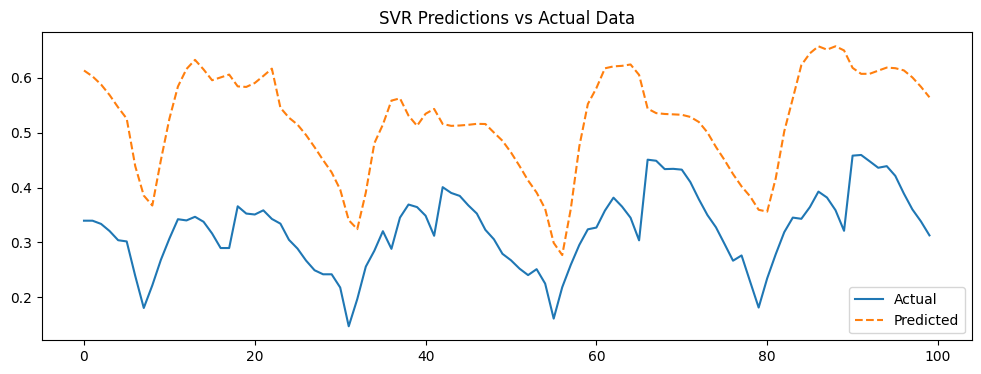

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
plt.plot(y_test[:100], label = "Actual")
plt.plot(y_test_pred[:100], label = "Predicted", linestyle = "dashed")
plt.legend()
plt.title("SVR Predictions vs Actual Data")
plt.show()